# **Modelling and Evaluation Notebook**

## Objectives

* This notebook will assess and choose which algorithm and hyperperameters are to be used for this ML task

## Inputs

* We will use the Train and Test datasets saved within outputs/datasets/train_test_initial

## Outputs

* A fully reviewed and tested model ready for dashboard

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [4]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Project5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [5]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [6]:
current_dir = os.getcwd()
current_dir

'/workspaces/Project5'

---

# GridSeachCV

We will use GridSearchCV and optimise the hyperparameters to select the most appropriate model.

We will compare several regressors to review and select the top performing algorithm.

The models selected are the below regressors:

* Decision Trees
* XGBoost (Extreme Gradient Boost)
* Gradient Boost
* Random Forest
* Linear Regression
* Ridge
* Lasso
* Ada Boost
* Extra Trees

We start by importing the standard scaler and feature selectors, along with the models and the pipeline setup. 

In [7]:
from sklearn.pipeline import Pipeline

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("feat_scaling", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

We will use the same Hyperparameter optimisation class that was used in the Churnometer walkthrough project.

This will review the models and supply a dataframe listing the results of each model using the below:
* 'estimator' (Regressor)
* 'min_score'
* 'max_score'
* 'mean_score'
* 'std_score' (Standard Deviation)

In [8]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

Here, we use the default parameters of each regressor

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    'Ridge': {},
    'Lasso': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Now, we import the train and test sets for use in the modelling.

In [10]:
import pandas as pd

features_train = pd.read_csv("outputs/datasets/train_test_initial/features_train.csv")
features_test = pd.read_csv("outputs/datasets/train_test_initial/features_test.csv")
target_train = pd.read_csv("outputs/datasets/train_test_initial/target_train.csv").squeeze()
target_test = pd.read_csv("outputs/datasets/train_test_initial/target_test.csv").squeeze()

We then call the HyperparameterOptimizationSearch using the default models and paramaters above.  We fit the train sets to the models, folding 5 times, and use r2 as our scoring comparison.

In [11]:
import warnings
warnings.filterwarnings("ignore")

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(features_train, target_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for Ridge 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Lasso 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_spars

Next, we call the score summary and sort it by mean score.  We see the GridSearchCV results below.

Ridge, Linear Regression and Lasso are now the front-runners.

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
1,Ridge,-0.070627,0.505489,0.896469,0.323573
0,LinearRegression,-0.068719,0.485653,0.89697,0.313883
2,Lasso,-2.569001,-0.3362,0.852802,1.225345
5,ExtraTreesRegressor,-2.892245,-1.176715,0.630228,1.432602
7,GradientBoostingRegressor,-3.885574,-1.331177,0.264087,1.714697
3,DecisionTreeRegressor,-2.678194,-1.482661,0.318054,1.298412
4,RandomForestRegressor,-2.663719,-1.523795,0.226616,1.286428
8,XGBRegressor,-3.628758,-1.702099,0.564055,1.61876
6,AdaBoostRegressor,-4.085896,-2.06909,0.102259,1.857491


We now set model hyperparamters as per below:

```
params_search = { "Ridge": { 
    'model__alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0], 
}
```

```
params_search = { "Lasso": { 
    'model__alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0], 
}
```

Note that Linear Regression takes no hyperparameters so this stays as is.

In [13]:
models_search = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
}

params_search = {
    "LinearRegression": {},

    "Ridge": {
        'model__alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0]
    },

    "Lasso": {
        'model__alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0]
    },
}

We again call the HyperparameterOptimizationSearch class using the above.

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(features_train, target_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Ridge 

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running GridSearchCV for Lasso 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


We then review the scores and the best parameters.

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__alpha
1,Ridge,-0.068906,0.506449,0.89692,0.323087,0.1
2,Ridge,-0.069664,0.506023,0.896719,0.3233,0.5
3,Ridge,-0.070627,0.505489,0.896469,0.323573,1.0
4,Ridge,-0.078856,0.501135,0.894525,0.325944,5.0
5,Ridge,-0.089993,0.495594,0.892225,0.329216,10.0
0,LinearRegression,-0.068719,0.485653,0.89697,0.313883,NaN
6,Ridge,-0.124747,0.479151,0.886129,0.339539,25.0
9,Lasso,-0.088944,0.475757,0.893871,0.33167,0.1
7,Ridge,-0.178227,0.45359,0.878089,0.355298,50.0
8,Ridge,-0.263878,0.407066,0.866776,0.380475,100.0


We see that there is a slight improvement in mean scores.  Ridge and Linear Regression are stronger than Lasso.

From this, we get the best estimators per model.

In [16]:
best_models = {
    "LinearRegression": grid_search_pipelines["LinearRegression"].best_estimator_,
    "Ridge": grid_search_pipelines["Ridge"].best_estimator_,
    "Lasso": grid_search_pipelines["Lasso"].best_estimator_
}

Then  we compare the models' performance against eachother:

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

selected_features = [
        'Bitcoin_Close_lag30_boxcox',
        'Nasdaq_Close_lag30_boxcox',
        'CPI_lag30_boxcox',
        'Retail_Sales_lag30_boxcox',
        'M2_Money_Supply_lag30_boxcox',
        'Real_GDP_lag30'
]

results = {}

for name, model in best_models.items():
    preds = model.predict(features_test[selected_features])
    results[name] = {
        "MSE": mean_squared_error(target_test, preds),
        "RMSE": mean_squared_error(target_test, preds, squared=False),
        "MAE": mean_absolute_error(target_test, preds),
        "R²": r2_score(target_test, preds)
    }

results_df = pd.DataFrame(results).T.sort_values(by="R²", ascending=False)
print(results_df)

                       MSE      RMSE       MAE        R²
Ridge             0.628559  0.792817  0.671569  0.904638
LinearRegression  0.628560  0.792818  0.671554  0.904637
Lasso             0.660239  0.812551  0.677672  0.899831


Ridge Regression has become the number 1 choice to move the project forward.  

First, however, we would like to compare the models again the actual BitCoin price and plot them on a graph.

We see slight deviation from the BitCoin price, but given the volatility of the BitCoin price, our prediction is moving in the right direction and is a good indicator of future price fluctuations.

Note that we are predicting the price a month into the future.

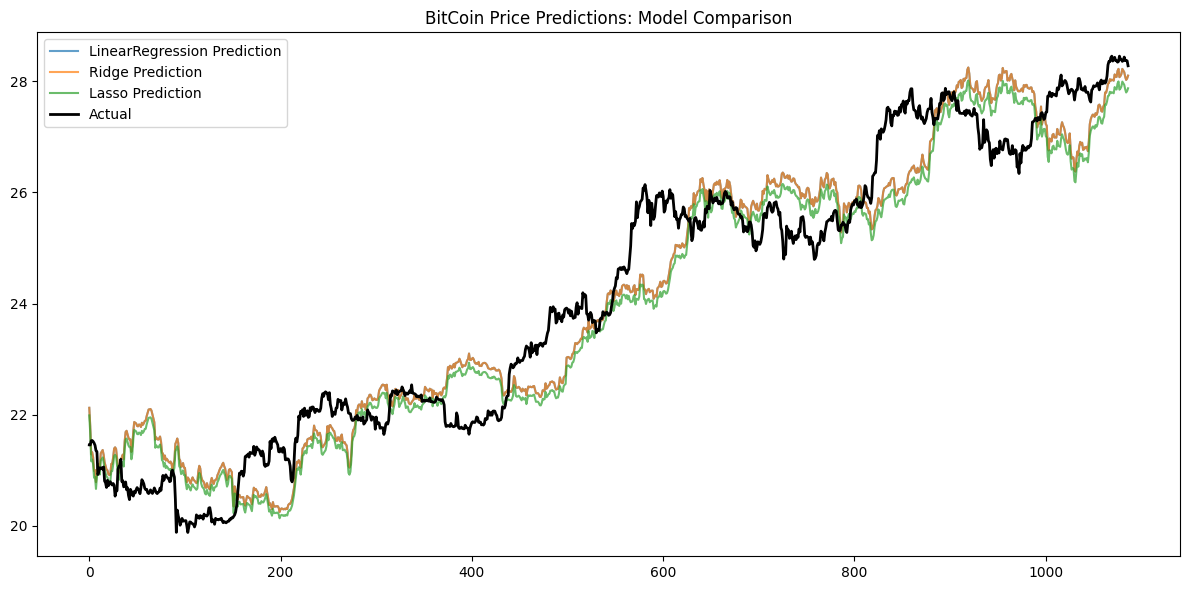

In [18]:
import matplotlib.pyplot as plt
import os
os.makedirs("outputs/datasets/figs", exist_ok=True)

fig = plt.figure(figsize=(12, 6))
for name, model in best_models.items():
    preds = model.predict(features_test[selected_features])
    plt.plot(preds, label=f"{name} Prediction", alpha=0.7)

plt.plot(target_test.values, label="Actual", color="black", linewidth=2)
plt.title("BitCoin Price Predictions: Model Comparison")
plt.legend()
plt.tight_layout()
plt.show()

fig.savefig("outputs/datasets/figs/models_versus_actual.png", dpi=300)

We'll get the best estimators per model:

In [19]:
best_model_lr = grid_search_pipelines["LinearRegression"].best_estimator_

In [20]:
best_model_rr = grid_search_pipelines["Ridge"].best_estimator_

In [21]:
best_model_lo = grid_search_pipelines["Lasso"].best_estimator_

Then we will see what features were most important in the predictions:

In [22]:
def feature_importances(best_models, feature_names):
    import numpy as np

    for name, pipeline in best_models.items():
        print(f"\n Selected Feature Importances for {name}:")

        model = pipeline.named_steps["model"]

        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_)
        else:
            print("  (No importances available)")
            continue

        importance_dict = dict(zip(feature_names, importances))
        sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

        for feature, score in sorted_importances:
            print(f"  {feature}: {score:.4f}")

We see that Ridge Regression uses lagged BitCoin and Nasdaq prices.

In [23]:
selected_features = [
    'Bitcoin_Close_lag30_boxcox',
    'Nasdaq_Close_lag30_boxcox',
    'CPI_lag30_boxcox',
    'Retail_Sales_lag30_boxcox',
    'M2_Money_Supply_lag30_boxcox',
    'Real_GDP_lag30'
]

feature_importances(best_models, selected_features)


 Selected Feature Importances for LinearRegression:
  Bitcoin_Close_lag30_boxcox: 5.6914
  Nasdaq_Close_lag30_boxcox: 1.6283

 Selected Feature Importances for Ridge:
  Bitcoin_Close_lag30_boxcox: 5.6892
  Nasdaq_Close_lag30_boxcox: 1.6303

 Selected Feature Importances for Lasso:
  Bitcoin_Close_lag30_boxcox: 5.6529
  Nasdaq_Close_lag30_boxcox: 1.5660


Finally, we will visualise the coefficients in our Ridge Regression model and Linear Regression model.

We can see that the strongest predictor is BitCoin's lagged price, but Nasdaq's lagged price adds meaningful context.

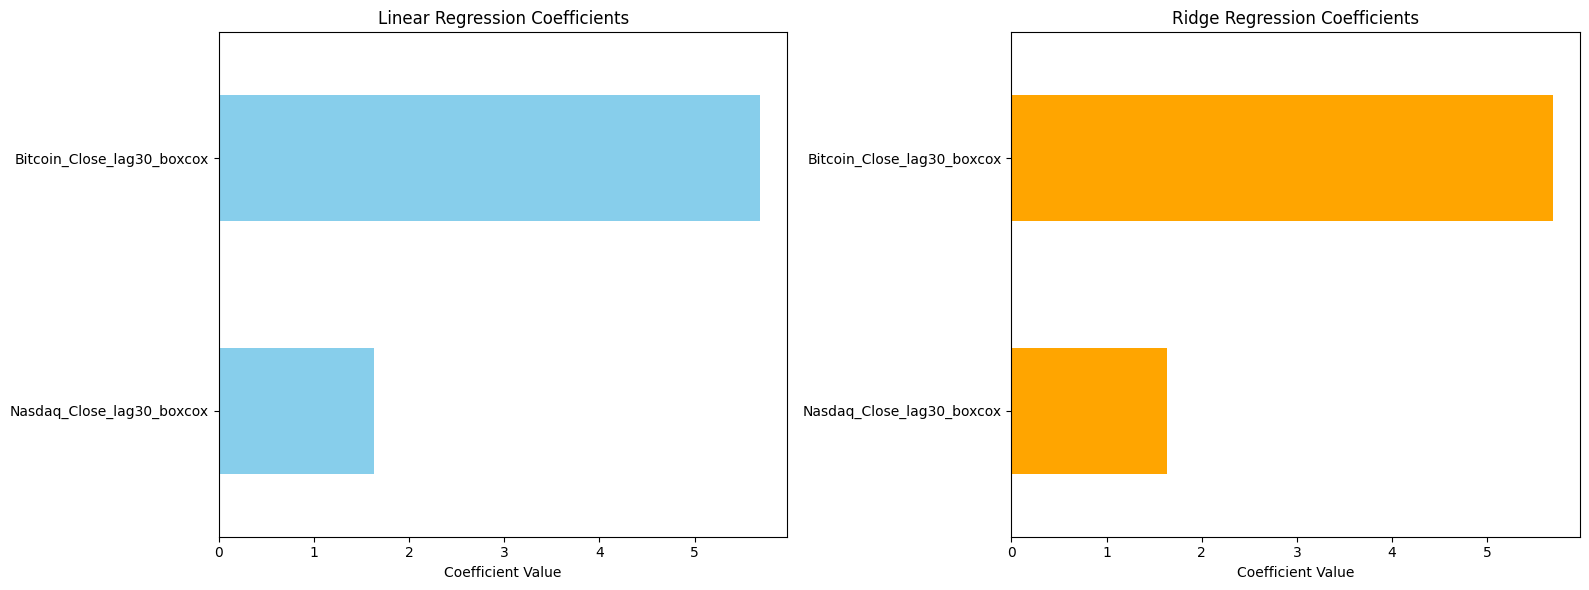

In [24]:
import os
import matplotlib.pyplot as plt
import pandas as pd

os.makedirs("outputs/datasets/figs", exist_ok=True)

# Get selected features from Linear pipeline
selected_mask_lr = best_model_lr.named_steps['feat_selection'].get_support()
selected_names_lr = [f for f, keep in zip(selected_features, selected_mask_lr) if keep]

# Get coefficients from Linear model
linear_model = best_model_lr.named_steps['model']
linear_coeffs = pd.Series(linear_model.coef_, index=selected_names_lr)

# Get selected features from Ridge pipeline
selected_mask_rr = best_model_rr.named_steps['feat_selection'].get_support()
selected_names_rr = [f for f, keep in zip(selected_features, selected_mask_rr) if keep]

# Get coefficients from Ridge model
ridge_model = best_model_rr.named_steps['model']
ridge_coeffs = pd.Series(ridge_model.coef_, index=selected_names_rr)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Linear Regression plot
linear_coeffs.sort_values().plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title("Linear Regression Coefficients")
axes[0].set_xlabel("Coefficient Value")

# Ridge Regression plot
ridge_coeffs.sort_values().plot(kind='barh', ax=axes[1], color='orange')
axes[1].set_title("Ridge Regression Coefficients")
axes[1].set_xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

# Save figure
fig.savefig("outputs/datasets/figs/linear_vs_ridge_coefficients.png", dpi=300)


Apply the 'best_model':

In [25]:
best_model = grid_search_pipelines["Ridge"].best_estimator_

print(best_model)

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('feat_selection', SelectFromModel(estimator=Ridge())),
                ('model', Ridge(alpha=0.1))])


We now run our model and see we're getting an R2 score of 0.945628, which is stll over our 0.90 target:

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

selected_features = [
    'Bitcoin_Close_lag30_boxcox',
    'Nasdaq_Close_lag30_boxcox',
    'CPI_lag30_boxcox',
    'Retail_Sales_lag30_boxcox',
    'M2_Money_Supply_lag30_boxcox',
    'Real_GDP_lag30'
]

preds = best_model_rr.predict(features_test[selected_features])

results = {
    "MSE": mean_squared_error(target_test, preds),
    "RMSE": mean_squared_error(target_test, preds, squared=False),
    "MAE": mean_absolute_error(target_test, preds),
    "R²": r2_score(target_test, preds)
}


results_df_final = pd.DataFrame([results], index=["Ridge"])
print(results_df_final)

            MSE      RMSE       MAE        R²
Ridge  0.628559  0.792817  0.671569  0.904638


Now, we will perform our model evaluation on the train and test sets using Linear Regression.

We use the below function, which evaluates the model performance and also plots the performance on a scatter plot.

In [29]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.makedirs("outputs/datasets/figs", exist_ok=True)

def regression_performance(features_train, target_train, features_test, target_test, best_model_rr):
    print("Model Evaluation\n")
    print("* Train Set")
    regression_evaluation(features_train, target_train, best_model_rr)
    print("* Test Set")
    regression_evaluation(features_test, target_test, best_model_rr)

def regression_evaluation(features, target, best_model_rr):
    predictions = best_model_rr.predict(features)
    print('R² Score:', r2_score(target, predictions).round(3))
    print('Mean Absolute Error:', mean_absolute_error(target, predictions).round(3))
    print('Mean Squared Error:', mean_squared_error(target, predictions).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(target, predictions)).round(3))
    print("\n")

def regression_evaluation_plots(features_train, target_train, features_test, target_test, best_model_rr, alpha_scatter=0.5):
    predictions_train = best_model_rr.predict(features_train)
    predictions_test = best_model_rr.predict(features_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.scatterplot(x=target_train, y=predictions_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=target_train, y=target_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=target_test, y=predictions_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=target_test, y=target_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predicted")
    axes[1].set_title("Test Set")

    plt.tight_layout()
    plt.show()

    fig.savefig("outputs/datasets/figs/train_test_review_boxcox.png", dpi=300)


We can see that the results are quite good!  Both datasets managed an R2 score of .90+.  

As expected, there is slightly more deviation on the test plot, but the levels are acceptable given BitCoin's volatility.

Model Evaluation

* Train Set
R² Score: 0.978
Mean Absolute Error: 0.823
Mean Squared Error: 1.22
Root Mean Squared Error: 1.104


* Test Set
R² Score: 0.905
Mean Absolute Error: 0.672
Mean Squared Error: 0.629
Root Mean Squared Error: 0.793




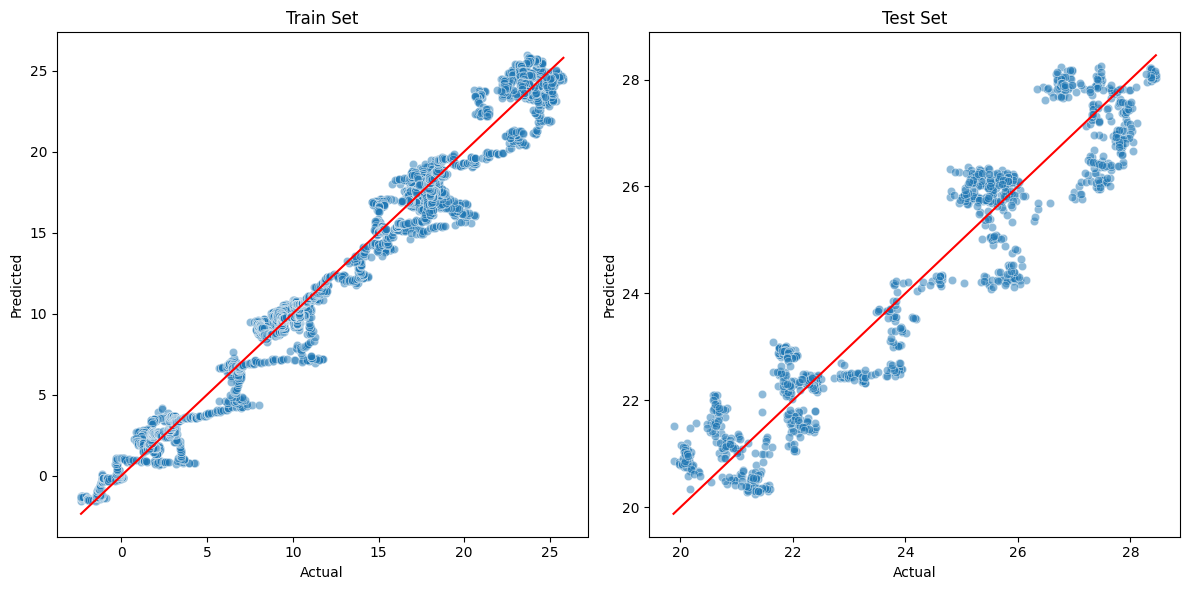

In [30]:
regression_performance(features_train, target_train, features_test, target_test, best_model_rr)
regression_evaluation_plots(features_train, target_train, features_test, target_test, best_model_rr)

---

# Back-Transform Predictions and Targets

Here, we reverse engineer the prediction by removing the Box Cox manipulation that was performed in the Feature Engineering section.  

We take the Lambda Target value that was applied, and perform the inverse of Box Cox to get an actual quantifiable result, easy for user understanding.

In [31]:
from scipy.special import inv_boxcox

lambda_target = 0.1347407526217442 # See Features Engineering workbook

model = best_model_rr

# Back-transform predictions
preds_train = inv_boxcox(model.predict(features_train), lambda_target)
preds_test = inv_boxcox(model.predict(features_test), lambda_target)

# Back-transform actual targets
actual_train = inv_boxcox(target_train, lambda_target)
actual_test = inv_boxcox(target_test, lambda_target)

We then run the predictions on the Train and Test sets:

In [32]:
def plot_back_transformed_predictions(actual_train, preds_train, actual_test, preds_test):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import r2_score

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Train Set
    sns.scatterplot(x=actual_train, y=preds_train, alpha=0.5, ax=axes[0])
    sns.lineplot(x=actual_train, y=actual_train, color='red', ax=axes[0])

    # Test Set
    sns.scatterplot(x=actual_test, y=preds_test, alpha=0.5, ax=axes[1])
    sns.lineplot(x=actual_test, y=actual_test, color='red', ax=axes[1])

    r2_train = r2_score(actual_train, preds_train)
    r2_test = r2_score(actual_test, preds_test)
    axes[0].set_title(f"Train Set: Actual vs. Predicted (R² = {r2_train:.3f})")
    axes[1].set_title(f"Test Set: Actual vs. Predicted (R² = {r2_test:.3f})")

    axes[0].set_xlabel("Actual Bitcoin Price")
    axes[0].set_ylabel("Predicted Bitcoin Price")
    axes[1].set_xlabel("Actual Bitcoin Price")
    axes[1].set_ylabel("Predicted Bitcoin Price")

    plt.tight_layout()
    plt.show()

The plots have more variance along the red line.  There are some large swings but in general the test set performed quite well.  

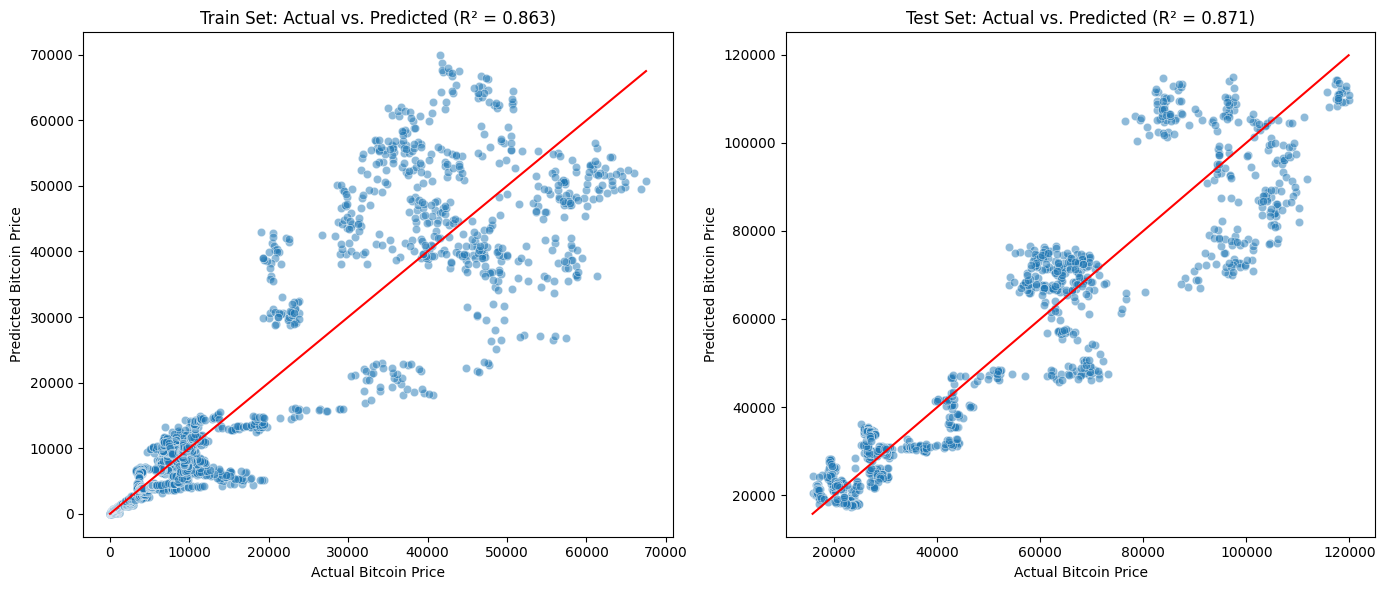

In [33]:
plot_back_transformed_predictions(actual_train, preds_train, actual_test, preds_test)

Here, we will get the performance, led by R2 on the test set:

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def print_original_metrics(actual, predicted, label="Test"):
    print(f"\n{label} Set Performance (Original Scale)")
    print("R² Score:", round(r2_score(actual, predicted), 3))
    print("MAE:", round(mean_absolute_error(actual, predicted), 3))
    print("MSE:", round(mean_squared_error(actual, predicted), 3))
    print("RMSE:", round(np.sqrt(mean_squared_error(actual, predicted)), 3))

We can summarise the performance as follows:

* R2 - The model shows stong generalisation and predictive power and can explain 87.1% of the variance of the BitCoin price 30 days ahead.
* MAE - On average, the predictions were off by $8,223.37, which is decent given BitCoin's volatility.
* MSE - $119,391,777 - Average squared error.  This is large as BitCoin's price itself is large.
* RMSE - $10,926.65 - Most of our forecasts fall within +/- $10,926.65 of the actual price.  

In [35]:
print_original_metrics(actual_test, preds_test, label="Test")


Test Set Performance (Original Scale)
R² Score: 0.871
MAE: 8223.367
MSE: 119391776.995
RMSE: 10926.654


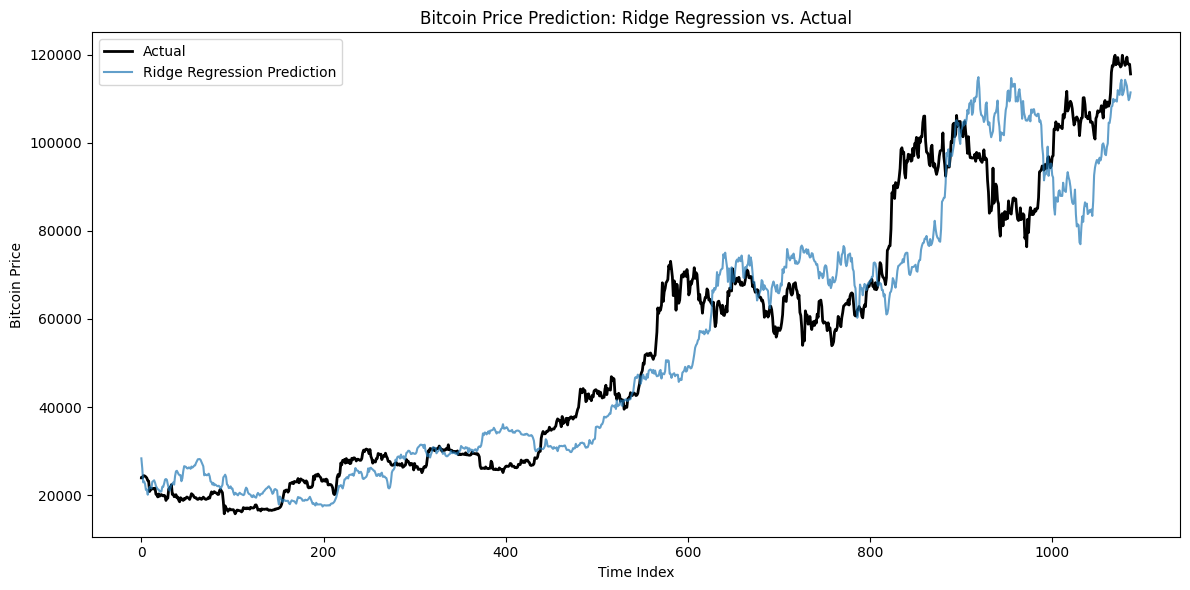

In [38]:
import os
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox

os.makedirs("outputs/datasets/figs", exist_ok=True)

lambda_target = 0.1347407526217442

model = best_model_rr
preds = model.predict(features_test[selected_features])

preds_bt = inv_boxcox(preds, lambda_target)
actual_bt = inv_boxcox(target_test, lambda_target)

fig = plt.figure(figsize=(12, 6))
plt.plot(actual_bt, label="Actual", color="black", linewidth=2)
plt.plot(preds_bt, label="Ridge Regression Prediction", alpha=0.7)

plt.title("Bitcoin Price Prediction: Ridge Regression vs. Actual")
plt.xlabel("Time Index")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.tight_layout()
plt.show()

fig.savefig("outputs/datasets/figs/linear_regression_vs_actual.png", dpi=300)

---

# Summary

In this notebook, we determined that Linear Regression was the best model for our data.  

We performed a hyperparameter search to determine the best parameters for use in our model.  Linear Regression beat both Ridge and Lasso models.

We then evaluated our model using both the Train and Test datasets.  The evaluation is as follows:

| Metric | Test Set        | Interpretation                                                  |
|--------|-----------------|-----------------------------------------------------------------|
|   R2   |   0.871         | Good generalisation.  Explains 87.1% of variance on unseen data |
|   MAE  |   $8,223.37     | Prediction error is reasonable.                                 |
|   RMSE |   $10,926.65    | The range within which our predictions fall.  Decent for BitCoin|
|   MSE  |   $119,391,777  | Higher suqared error on the test set as expected                |

Overall, the model confirms that:
* The Train and Test scores are relatively close
* The accuracy is consistent - MAE and RMSE are stable given BitCoin prices and swings
* The model handles unseen data with confidence

---

# Push files to the repo

We will generate the following files:

* Modeling pipeline
* Regression evaluation plots

Create the ml_pipeline folder in outputs.

In [39]:
import joblib
import os

version = 'v2'
file_path = f'outputs/ml_pipeline/predict_btc_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_btc_price/v2'


Save the ML Pipeline.

In [40]:
pipeline_btc = grid_search_pipelines["Ridge"].best_estimator_
pipeline_btc

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('feat_selection', SelectFromModel(estimator=Ridge())),
                ('model', Ridge(alpha=0.1))])

In [41]:
joblib.dump(value=pipeline_btc, filename=f"{file_path}/btc_pipeline_rr.pkl")

['outputs/ml_pipeline/predict_btc_price/v2/btc_pipeline_rr.pkl']

In [42]:
print(pipeline_btc.feature_names_in_)

['Bitcoin_Close_lag30_boxcox' 'Nasdaq_Close_lag30_boxcox'
 'CPI_lag30_boxcox' 'Retail_Sales_lag30_boxcox'
 'M2_Money_Supply_lag30_boxcox' 'Real_GDP_lag30']


### We've now saved our ML Pipeline and can proceed to the dashboard creation